<H1>Relationship between IL and price change in a stableswap pool</H1>
Here we investigate the impermanent loss experienced by an LP in an unrelated asset in the Omnipool when one of the assets in a stableswap subpool depegs (its value deviates from 1USD). Because subpool shares can be reinvested in the Omnipool just like any other asset, and because all Omnipool assets share exposure to LRNA, all Omnipool LPs are indirectly exposed to the assets in the subpool. In these experiments, an LP contributes a small quantity of ETH and we measure what percentage of that investment is lost when one of the stableswap assets changes price. We'll examnine the effects of the weight of the stableswap shares in the Omnipool and the subpool's amplification constant.
<br><br>
Withdrawal fee is not included in these calculations, so the assumption is that the LP waits until volatility has subsided before withdrawing their assets.

In [115]:
import sys
import random
import copy
import math
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, execute_remove_liquidity, cash_out_omnipool, value_assets, usd_price, lrna_price, execute_create_sub_pool
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.01, 'weight': 0.05},
    'DAI': {'usd price': 1, 'weight': 0.1},
    'USDA': {'usd price': 1, 'weight': 0.005},
    'USDB': {'usd price': 1, 'weight': 0.005},
    'ETH': {'usd price': 1000, 'weight': 0.749}
}

# assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000
initial_lrna_price = 22

omnipool = OmnipoolState(
    tokens={
        tkn: {
            'liquidity': initial_tvl * assets[tkn]['weight'] / assets[tkn]['usd price'],
            'LRNA': initial_tvl * assets[tkn]['weight'] / initial_lrna_price
        }
        for tkn in assets
    },
    preferred_stablecoin='DAI',
    withdrawal_fee=False
)

initial_state = GlobalState(
    pools={
        'omnipool': omnipool
    },
    agents = {
        'LP1': Agent(
            holdings={'USDA': 45000, 'USDB': 45000},
            trade_strategy=invest_all('stableswap')
        ),
        'LP2': Agent(
            holdings={'ETH': 1},
            trade_strategy=invest_all('omnipool')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)

execute_create_sub_pool(
    state=omnipool,
    tkns_migrate={'USDA': omnipool.liquidity['USDA'], 'USDB': omnipool.liquidity['USDB']},
    sub_pool_id='stableswap',
    amplification=100,
    trade_fee=0
)

arbitrageur = Agent(
    holdings={tkn: float('inf') for tkn in omnipool.asset_list},
    trade_strategy=omnipool_arbitrage(
        pool_id='omnipool',
        arb_precision=2
    )
)

initial_state.pools['stableswap'] = omnipool.sub_pools['stableswap']
invested_state = run.run(initial_state, time_steps=1, silent=True)[-1]
# have LP1 invest their stableswap shares in the omnipool, reaching a total weight of 10%
OmnipoolState.execute_add_liquidity(
    state=invested_state.pools['omnipool'],
    agent=invested_state.agents['LP1'],
    tkn_add='stableswap',
    quantity=invested_state.agents['LP1'].holdings['stableswap']
)
# print(invested_state.pools['omnipool'])

Omnipool: omnipool
********************************
tvl cap: inf
lrna fee:

    HDX: 0%
    DAI: 0%
    ETH: 0%
    stableswap: 0.0%

asset fee:

    HDX: 0%
    DAI: 0%
    ETH: 0%
    stableswap: 0.0%

asset pools: (

    *HDX*
    asset quantity: 5000000.0
    lrna quantity: 2272.727272727273
    USD price: 0.01
    tvl: $50000.000000000015
    weight: 2272.727272727273/45454.54545454545 (0.05000000000000001)
    weight cap: 1
    total shares: 5000000.0
    protocol shares: 5000000.0

    *DAI*
    asset quantity: 100000.0
    lrna quantity: 4545.454545454545
    USD price: 1.0
    tvl: $100000.0
    weight: 4545.454545454545/45454.54545454545 (0.1)
    weight cap: 1
    total shares: 100000.0
    protocol shares: 100000.0

    *ETH*
    asset quantity: 750.0
    lrna quantity: 34090.90909090909
    USD price: 1000.0
    tvl: $750000.0
    weight: 34090.90909090909/45454.54545454545 (0.75)
    weight cap: 1
    total shares: 750.0
    protocol shares: 749.0

    *stableswap*
    as

In [86]:
amps = [12.5, 25, 50, 100, 200]
trade_range = [115000, 98000, 85000, 75000, 68000]
steps = 1000
amp_events = []
original_stableswap_price = usd_price(initial_state.pools['omnipool'], 'stableswap')
for i, amplification in enumerate(amps):
    invested_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -trade_range[i], trade_range[i]
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    events = []
 
    for trade_size in trade_sizes:
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.

        event = invested_state.copy().execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=abs(trade_size),
        )
        # LP1 withdraws so we can measure the new price of stableswap shares
        StableSwapPoolState.execute_remove_uniform(
            state=event.pools['stableswap'],
            agent=event.agents['LP1'],
            shares_removed=event.agents['LP1'].holdings['stableswap']
        )
        
        event.external_market['USDA'] = 1 / event.pools['stableswap'].spot_price
        LP1_deposit_value = value_assets(prices=event.external_market, assets=initial_state.agents['LP1'].initial_holdings)
        LP1_asset_value = value_assets(prices=event.external_market, assets=event.agents['LP1'].holdings)
        stableswap_share_price = original_stableswap_price * LP1_asset_value / LP1_deposit_value
        event.external_market['stableswap'] = stableswap_share_price
        event.agents['arbitrageur'] = arbitrageur
        arbitrageur.trade_strategy.execute(event, 'arbitrageur')
        
        events.append(event)

    amp_events.append(events)
    
print('simulation finished.')

simulation finished.


<H3>Varying the amplification in the stableswap subpool</H3>
Other than asset price, the biggest factor affecting impermanent loss in the stableswap subpool is its amplification constant. Here we measure the impermanent loss incurred by an LP invested in ETH when an asset in the stableswap subpool comprising 10% of TVL depegs, as a function of depegged asset price and subpool amplification.

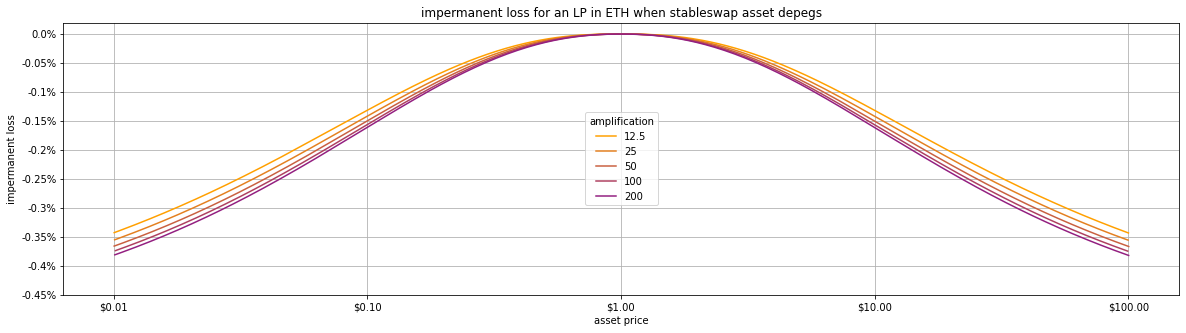

In [91]:
colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
price_max = 100
ax = plt.figure(figsize=(20, 5)).add_subplot(111)
for i, amp in enumerate(amps):
    deposit_vals = [
        value_assets(prices=event.external_market, assets=initial_state.agents['LP2'].holdings)
        for event in amp_events[i]
    ]
    withdraw_vals = [
        cash_out_omnipool(event.pools['omnipool'], agent=event.agents['LP2'], prices=event.external_market)
        for event in amp_events[i]
    ]

    usda_prices = [event.external_market['USDA'] for event in amp_events[i]]
    impermanent_loss = [withdraw_vals[i] / deposit_vals[i] - 1 for i in range(len(amp_events[i]))]
    center = usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - 1))[0])

    range_width = abs(center - usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - price_max))[0]))
    start_range = center - range_width
    end_range = center + range_width
    ax.plot(usda_prices[start_range: end_range], impermanent_loss[start_range: end_range], color=colors[i])
    plt.title(f'impermanent loss for an LP in ETH when stableswap asset depegs')
    plt.legend(amps, loc='center', title='amplification')

plt.xscale('log')

# clear default ticks
for t in plt.gca().xaxis.get_minor_ticks():
    t.set_visible(False)

price_min = 1 / price_max
xticks = (
    round(1 / price_max * 100) / 100,
    round(math.exp(math.log(price_min) / 2) * 100) / 100,
    1.0,
    round(math.exp(math.log(price_max) / 2) * 100) / 100,
    round(price_max * 100) / 100
)
xlabels = [f'${tick}' for tick in xticks]
xlabels = [label + "0" * (3 - (len(label[label.index('.'):])) if '.' in label else 0) for label in xlabels]
plt.xticks(
    xticks,
    xlabels
)
yticks = ax.get_yticks().tolist()[:-1]
ax.set_yticks(
    yticks, 
    [str(round(tick * 100, 6)) + '%' for tick in yticks]
)
plt.xlabel('asset price')
plt.ylabel('impermanent loss')
plt.grid()
plt.show()


In [86]:
trade_range = [115000, 98000, 85000, 75000, 68000]
steps = 1000
amp_events = []
original_stableswap_price = usd_price(initial_state.pools['omnipool'], 'stableswap')
for i, amplification in enumerate(amps):
    invested_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -trade_range[i], trade_range[i]
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    events = []
 
    for trade_size in trade_sizes:
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.

        event = invested_state.copy().execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=abs(trade_size),
        )
        # LP1 withdraws so we can measure the new price of stableswap shares
        StableSwapPoolState.execute_remove_uniform(
            state=event.pools['stableswap'],
            agent=event.agents['LP1'],
            shares_removed=event.agents['LP1'].holdings['stableswap']
        )
        
        event.external_market['USDA'] = 1 / event.pools['stableswap'].spot_price
        LP1_deposit_value = value_assets(prices=event.external_market, assets=initial_state.agents['LP1'].initial_holdings)
        LP1_asset_value = value_assets(prices=event.external_market, assets=event.agents['LP1'].holdings)
        stableswap_share_price = original_stableswap_price * LP1_asset_value / LP1_deposit_value
        event.external_market['stableswap'] = stableswap_share_price
        event.agents['arbitrageur'] = arbitrageur
        arbitrageur.trade_strategy.execute(event, 'arbitrageur')
        
        events.append(event)

    amp_events.append(events)
    
print('simulation finished.')

simulation finished.


<H3>Varying the weight in the Omnipool of the stableswap subpool</H3>
Within the Omnipool itself, the main driver of impermanent loss in an otherwise stable asset is LRNA price. LRNA price is sensitive to the price of every asset in the pool, in proportion to the relative weight of that asset. Here we measure the impermanent loss experienced by an LP in ETH when an asset depegs in a stableswap subpool comprising 1 - 20% of TVL.

--------------------------------------------
adding: 101.0101010101007
start_val: 0.011001100110011002
Omnipool: omnipool
********************************
tvl cap: inf
lrna fee:

    HDX: 0%
    DAI: 0%
    ETH: 0%
    stableswap: 0.0%

asset fee:

    HDX: 0%
    DAI: 0%
    ETH: 0%
    stableswap: 0.0%

asset pools: (

    *HDX*
    asset quantity: 5000000.0
    lrna quantity: 2272.727272727273
    USD price: 0.01
    tvl: $50000.000000000015
    weight: 2272.727272727273/41322.77318640955 (0.054999388895678944)
    weight cap: 1
    total shares: 5000000.0
    protocol shares: 5000000.0

    *DAI*
    asset quantity: 100000.0
    lrna quantity: 4545.454545454545
    USD price: 1.0
    tvl: $100000.0
    weight: 4545.454545454545/41322.77318640955 (0.10999877779135787)
    weight cap: 1
    total shares: 100000.0
    protocol shares: 100000.0

    *ETH*
    asset quantity: 749.0
    lrna quantity: 34045.454545454544
    USD price: 1000.0
    tvl: $749000.0000000001
    weight: 34045.

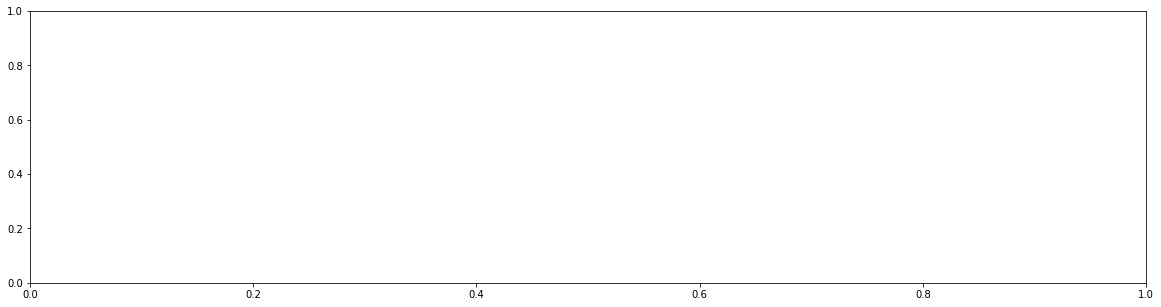

In [118]:
colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
weights = [0.01, 0.04, 0.10, 0.15, 0.20]
price_max = 100
ax = plt.figure(figsize=(20, 5)).add_subplot(111)
for i, weight in enumerate(weights):
    weight_state = initial_state.copy()
    start_val = weight_state.pools['omnipool'].lrna['stableswap'] / weight_state.pools['omnipool'].lrna_total
    add_amount = initial_tvl / (1 / weight - 1) - weight_state.pools['omnipool'].liquidity['stableswap'] * initial_lrna_price
    weight_state.agents['LP1'].holdings['USDA'] = add_amount / 2
    weight_state.agents['LP1'].holdings['USDB'] = add_amount / 2
    print('--------------------------------------------')
    print(f'adding: {add_amount}')
    print(f'start_val: {start_val}')
    # print(weight_state.agents['LP1'])
    weight_state.agents['LP1'].trade_strategy.execute(
        state=weight_state,
        agent_id='LP1'
    )
    OmnipoolState.execute_add_liquidity(
        state=weight_state.pools['omnipool'],
        agent=weight_state.agents['LP1'],
        tkn_add='stableswap',
        quantity=weight_state.agents['LP1'].holdings['stableswap']
    )
    print(weight_state.pools['omnipool'])
    # print(weight_state.agents['LP1'])

if 1 == 2:
    deposit_vals = [
        value_assets(prices=event.external_market, assets=initial_state.agents['LP2'].holdings)
        for event in amp_events[i]
    ]
    withdraw_vals = [
        cash_out_omnipool(event.pools['omnipool'], agent=event.agents['LP2'], prices=event.external_market)
        for event in amp_events[i]
    ]

    usda_prices = [event.external_market['USDA'] for event in amp_events[i]]
    impermanent_loss = [withdraw_vals[i] / deposit_vals[i] - 1 for i in range(len(amp_events[i]))]
    center = usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - 1))[0])

    range_width = abs(center - usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - price_max))[0]))
    start_range = center - range_width
    end_range = center + range_width
    ax.plot(usda_prices[start_range: end_range], impermanent_loss[start_range: end_range], color=colors[i])
    plt.title(f'impermanent loss for an LP in ETH when stableswap asset depegs')
    plt.legend(amps, loc='center', title='amplification')

    plt.xscale('log')

    # clear default ticks
    for t in plt.gca().xaxis.get_minor_ticks():
        t.set_visible(False)

    price_min = 1 / price_max
    xticks = (
        round(1 / price_max * 100) / 100,
        round(math.exp(math.log(price_min) / 2) * 100) / 100,
        1.0,
        round(math.exp(math.log(price_max) / 2) * 100) / 100,
        round(price_max * 100) / 100
    )
    xlabels = [f'${tick}' for tick in xticks]
    xlabels = [label + "0" * (3 - (len(label[label.index('.'):])) if '.' in label else 0) for label in xlabels]
    plt.xticks(
        xticks,
        xlabels
    )
    yticks = ax.get_yticks().tolist()[:-1]
    ax.set_yticks(
        yticks, 
        [str(round(tick * 100, 6)) + '%' for tick in yticks]
    )
    plt.xlabel('asset price')
    plt.ylabel('impermanent loss')
    plt.grid()
    plt.show()


amp: 12.5


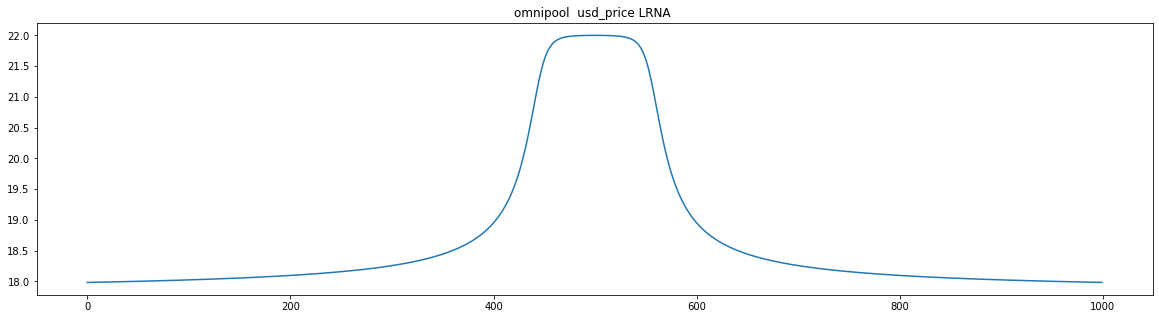

amp: 25


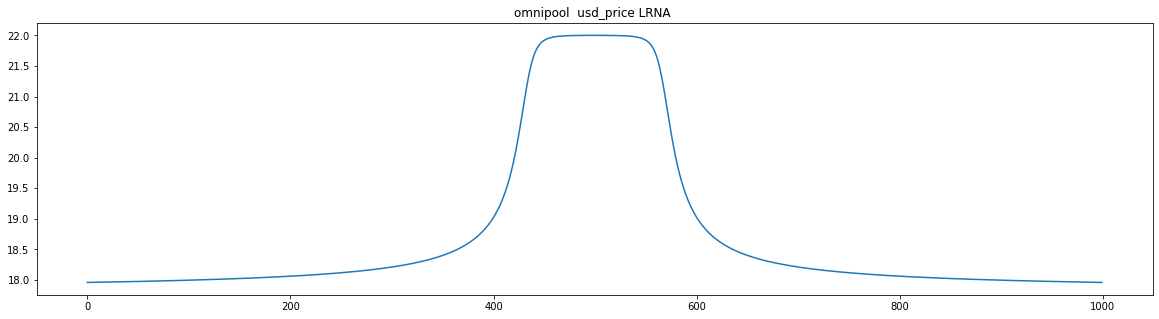

amp: 50


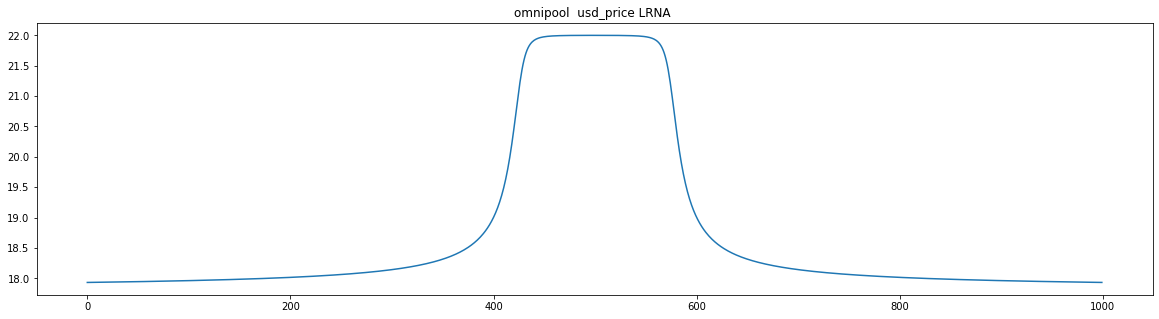

amp: 100


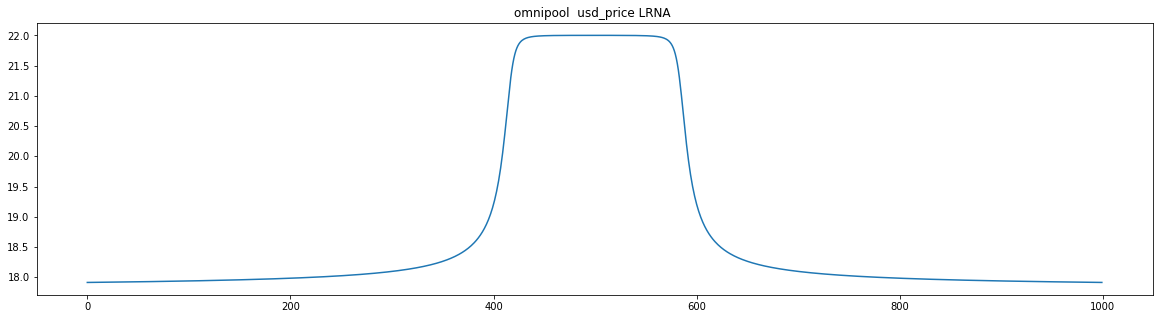

amp: 200


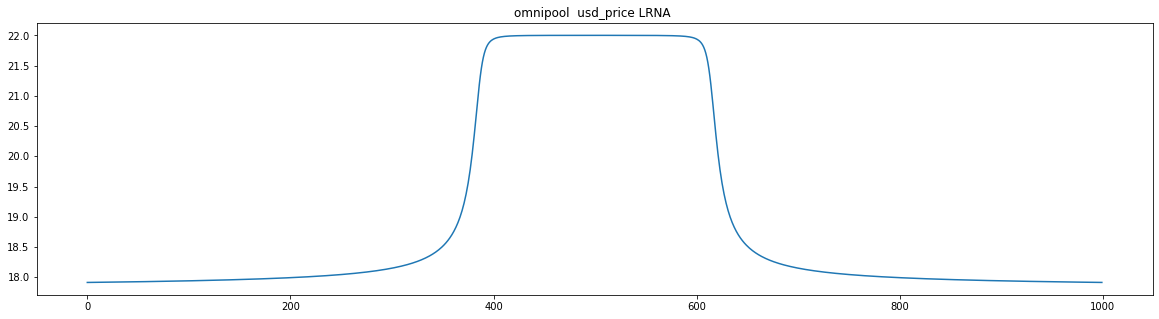

In [5]:
for i, amp in enumerate(amps):
    events = amp_events[i]
    print(f'amp: {amp}')
    # plt.figure(figsize=(20, 5))
    
    pu.plot(amp_events[i], pool='omnipool', prop='usd_price', key='LRNA')
    
    plt.show()

AttributeError: 'float' object has no attribute 'index'

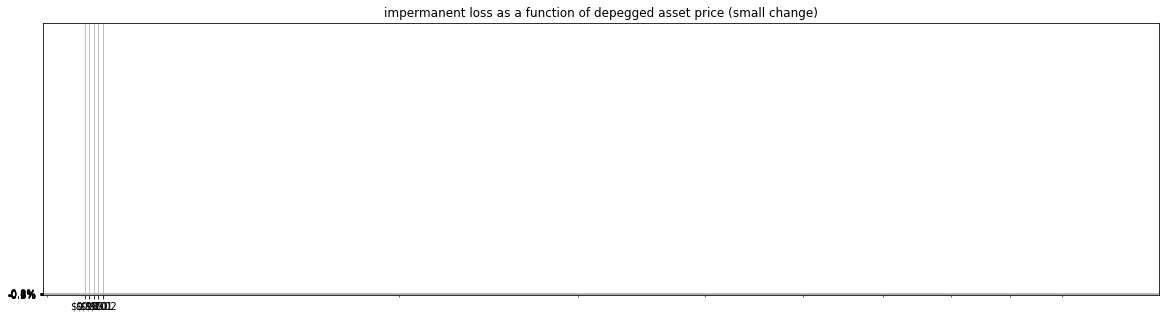

In [6]:
# display(Markdown(f'<H3>Impermanent Loss Dynamics at {amps[i]} Amplification</H3>'))
weights = [0.01, 0.05, 0.1, 0.
# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (small change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.98, 0.99, 1, 1.01, 1.02],
    ['$0.98', '$0.99', '$1.00', '$1.01', '$1.02']
)
plt.yticks(
    [-0.001 * i for i in range(7)],
    [f'-{round(0.1 * i * 10, 2) / 10}%' for i in range(7)]
)

for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1.022))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# medium zoom
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (medium change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.8, 0.9, 1, 1.12, 1.25],
    ['$0.80', '$0.90', '$1.00', '$1.12', '$1.25']
)
plt.yticks(
    [-0.02 * i for i in range(6)],
    [f'-{2 * i}%' for i in range(6)]
)

for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1.27))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# zoom out
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (extreme change, log scale)')
plt.xscale('log')
plt.grid()
plt.yscale('log')
plt.yticks(
    [1, 0.1, 0.01, 0.001],
    ['0%', '-90%', '-99%', '-99.9%']
)
tick_prices = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.xticks(
    tick_prices,
    ['$0.001', '$0.01', '$0.10', '$1.00', '$10', '$100', '$1000']
)

for i, loss in enumerate(impermanent_loss):
    center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
    range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1010))[0]))
    start_range = center - range_width
    end_range = center + range_width
    plt.plot(usda_prices[i][start_range: end_range], [1 + loss for loss in loss[start_range: end_range]], color=colors[i])

plt.legend(amps, loc='center', title='amplification')

plt.show()

In [ ]:
original_stableswap_price

In [ ]:
events[-1].agents['LP2'].holdings


In [ ]:
initial_state.agents['LP1'].initial_holdings

In [ ]:
arbitrageur.holdings['stableswap']

In [ ]:
print(lrna_price(initial_state.pools['omnipool'], 'ETH'))

In [ ]:
print(lrna_price)

In [78]:
(
    cash_out_omnipool(invested_state.pools['omnipool'], invested_state.agents['LP2'], prices = invested_state.external_market)
    / cash_out_omnipool(initial_state.pools['omnipool'], initial_state.agents['LP2'], prices = initial_state.external_market)
)
    

0.9998999999999999